In [1]:
# 데이터 로딩
from src.data_loader import(
load_building_info, load_and_merge,
split_building_types, encode_building)
from src.features import add_time_features, drop_unused_features

building = load_building_info()

# 건물 유형에 따른 데이터셋 분리
building_types = ['IDC(전화국)', '병원']
selected, rest = split_building_types(building, building_types=building_types)

#### 일반 유형 건물 전처리 및 학습

In [2]:
# 인코딩
building_encoded = encode_building(rest)

train_df = load_and_merge(building_info=building_encoded)
# 이상치 제거: 전력 소비량 0 제외
train_df = train_df[train_df['전력소비량(kWh)'] != 0]
train_df = add_time_features(train_df)
train_df = drop_unused_features(train_df)

In [3]:
# 전처리
from src.features import (
    fit_weather_pca, transform_weather_pca,
    split_features_target,
    scale_features, train_valid_split
)

scaler_w, pca_w = fit_weather_pca(train_df)
train_df = transform_weather_pca(train_df, scaler_w, pca_w)

X, y = split_features_target(train_df)
X_scaled, scaler = scale_features(X)
X_train, X_valid, y_train, y_valid = train_valid_split(X_scaled, y)

print(X_train.shape,X_valid.shape)  ## 열의 갯수가 같아야한다.
                                    ## y의 열 갯수는 1이여야함.
print(y_train.shape,y_valid.shape)  ## train , test 끼리는 행의 갯수가 같아야한다.

(133784, 18) (33447, 18)
(133784,) (33447,)


#### 모델링: 다중선형회귀, RF, XGB, LightGBM

In [4]:
from src.models import train_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

model_lr = train_model(LinearRegression, X_train, y_train)
model_rf = train_model(RandomForestRegressor, X_train, y_train, random_state=42, n_estimators=250)
model_xgb = train_model(XGBRegressor, X_train, y_train, n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)
model_lgbm = train_model(LGBMRegressor, X_train, y_train, random_state=42)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007949 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 818
[LightGBM] [Info] Number of data points in the train set: 133784, number of used features: 18
[LightGBM] [Info] Start training from score 2442.656463


#### 선택 유형 건물 전처리 및 학습

In [5]:
if building_types:
    # 인코딩
    building_encoded = encode_building(selected)
    
    train_df = load_and_merge(building_info=building_encoded)
    # 이상치 제거: 전력 소비량 0 제외
    train_df = train_df[train_df['전력소비량(kWh)'] != 0]
    train_df = add_time_features(train_df)
    train_df = drop_unused_features(train_df)
    
    scaler_w, pca_w = fit_weather_pca(train_df)
    train_df = transform_weather_pca(train_df, scaler_w, pca_w)
    
    X, y = split_features_target(train_df)
    X_scaled, scaler = scale_features(X)
    X_train_sel, X_valid_sel, y_train_sel, y_valid_sel = train_valid_split(X_scaled, y)
    
    print(X_train_sel.shape,X_valid_sel.shape)  ## 열의 갯수가 같아야한다.
                                                ## y의 열 갯수는 1이여야함.
    print(y_train_sel.shape,y_valid_sel.shape)  ## train , test 끼리는 행의 갯수가 같아야한다.
    
    model_lr_sel = train_model(LinearRegression, X_train_sel, y_train_sel)
    model_rf_sel = train_model(RandomForestRegressor, X_train_sel, y_train_sel, random_state=42, n_estimators=250)
    model_xgb_sel = train_model(XGBRegressor, X_train_sel, y_train_sel, n_estimators=1000, learning_rate=0.1, max_depth=6, random_state=42)
    model_lgbm_sel = train_model(LGBMRegressor, X_train_sel, y_train_sel, random_state=42)

(29360, 12) (7341, 12)
(29360,) (7341,)
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001041 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 652
[LightGBM] [Info] Number of data points in the train set: 29360, number of used features: 12
[LightGBM] [Info] Start training from score 7421.176955


#### 평가: SMAPE, MSE, R2, RMSE

In [6]:
from src.evaluate import evaluate_model
from src.models import predict_model
import numpy as np

result = []
if building_types:
    # building_types 분리 학습이 된 경우,
    # 전체(rest) 와 selected 모델을 함께 평가
    model_pairs = [
        ("Linear Regression", model_lr, model_lr_sel),
        ("Random Forest",    model_rf, model_rf_sel),
        ("XGBoost",          model_xgb, model_xgb_sel),
        ("LightGBM",         model_lgbm, model_lgbm_sel),
    ]

    for name, model_base, model_sel in model_pairs:
        # 1) 전체(rest) 데이터에 대한 예측
        y_pred_base = predict_model(model_base, X_valid)
        y_true_base = y_valid

        # 2) selected 데이터에 대한 예측
        y_pred_sel  = predict_model(model_sel, X_valid_sel)
        y_true_sel  = y_valid_sel

        # 3) 같은 순서로 합치기 (numpy 배열 혹은 pandas Series 모두 가능)
        y_pred_all = np.concatenate([y_pred_base, y_pred_sel])
        y_true_all = np.concatenate([y_true_base, y_true_sel])

        # 4) 합쳐진 값으로 평가
        result.append(evaluate_model(name, y_true_all, y_pred_all))

else:
    # building_types를 사용하지 않은 원래 루프
    for name, model in [
        ("Linear Regression", model_lr),
        ("Random Forest",    model_rf),
        ("XGBoost",          model_xgb),
        ("LightGBM",         model_lgbm),
    ]:
        y_pred = predict_model(model, X_valid)
        result.append(evaluate_model(name, y_valid, y_pred))

[Linear Regression] SMAPE: 56.8729 | MSE: 4940186.2820 | RMSE: 2222.6530 | R²: 0.6312
[Random Forest] SMAPE: 3.8409 | MSE: 30867.4403 | RMSE: 175.6913 | R²: 0.9977
[XGBoost] SMAPE: 8.2395 | MSE: 44137.4908 | RMSE: 210.0892 | R²: 0.9967
[LightGBM] SMAPE: 13.8306 | MSE: 122099.7932 | RMSE: 349.4278 | R²: 0.9909


C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(
C:\Users\user\anaconda3\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMRegressor was fitted with feature names
  warnings.warn(


In [7]:
# 이상치 제거 전
# LR //  SMAPE: 60.3657 | MSE : 6863788.1150 | R²: 0.4912
# RF //  SMAPE: 5.3089 | MSE : 64687.4852 | R²: 0.9952
# XGB //  SMAPE: 9.9646 | MSE : 76263.9994 | R²: 0.9943
# LightGBM //  SMAPE: 16.6444 | MSE : 224995.8211 | R²: 0.9833
# 이상치 제거 후
# [Linear Regression] SMAPE: 60.4158 | MSE: 6842011.1036 | RMSE: 2615.7238 | R²: 0.4911
# [Random Forest] SMAPE: 5.2542 | MSE: 68416.5490 | RMSE: 261.5656 | R²: 0.9949
# [XGBoost] SMAPE: 10.0876 | MSE: 79388.7909 | RMSE: 281.7602 | R²: 0.9941
# [LightGBM] SMAPE: 16.5264 | MSE: 234424.2056 | RMSE: 484.1737 | R²: 0.9826

In [8]:
# 요일 주기 반영
# 기본파
# [Linear Regression] SMAPE: 60.4566 | MSE: 6832388.7648 | RMSE: 2613.8838 | R²: 0.4918
# [Random Forest] SMAPE: 3.8748 | MSE: 38120.4761 | RMSE: 195.2447 | R²: 0.9972
# [XGBoost] SMAPE: 8.5240 | MSE: 54997.0147 | RMSE: 234.5144 | R²: 0.9959
# [LightGBM] SMAPE: 15.6952 | MSE: 173354.4212 | RMSE: 416.3585 | R²: 0.9871
# 2배파 반영
# [Linear Regression] SMAPE: 60.4739 | MSE: 6829623.9162 | RMSE: 2613.3549 | R²: 0.4920
# [Random Forest] SMAPE: 3.8605 | MSE: 37682.9217 | RMSE: 194.1209 | R²: 0.9972
# [XGBoost] SMAPE: 8.4292 | MSE: 53924.0352 | RMSE: 232.2155 | R²: 0.9960
# [LightGBM] SMAPE: 15.6429 | MSE: 172610.7366 | RMSE: 415.4645 | R²: 0.9872
# 3배파 반영
# [Linear Regression] SMAPE: 60.4634 | MSE: 6830244.1883 | RMSE: 2613.4736 | R²: 0.4920
# [Random Forest] SMAPE: 3.8608 | MSE: 37411.1531 | RMSE: 193.4196 | R²: 0.9972
# [XGBoost] SMAPE: 8.4497 | MSE: 53962.3332 | RMSE: 232.2979 | R²: 0.9960
# [LightGBM] SMAPE: 15.7225 | MSE: 173531.0542 | RMSE: 416.5706 | R²: 0.9871
# 2배파 제외(기본파, 3배파)
# [Linear Regression] SMAPE: 60.4537 | MSE: 6833033.2366 | RMSE: 2614.0071 | R²: 0.4918
# [Random Forest] SMAPE: 3.8556 | MSE: 37357.4254 | RMSE: 193.2807 | R²: 0.9972
# [XGBoost] SMAPE: 8.3865 | MSE: 53990.0236 | RMSE: 232.3575 | R²: 0.9960
# [LightGBM] SMAPE: 15.7179 | MSE: 172795.7135 | RMSE: 415.6870 | R²: 0.9871

# 시각화

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [10]:
model_performance = pd.DataFrame(result)

C:\Users\user\AppData\Local\Temp\ipykernel_9220\3467791523.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='SMAPE', data=model_performance.sort_values(by='SMAPE'), palette='colorblind')


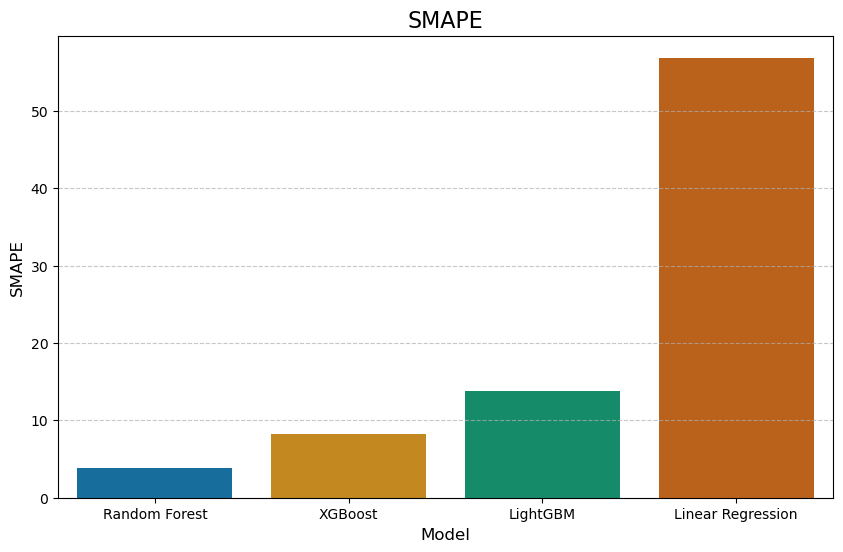

In [11]:
# 1. SMAPE 비교 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='SMAPE', data=model_performance.sort_values(by='SMAPE'), palette='colorblind')
plt.title('SMAPE', fontsize=16)
plt.ylabel('SMAPE', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9220\2491275805.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='RMSE', data=model_performance.sort_values(by='RMSE'), palette='Set2')


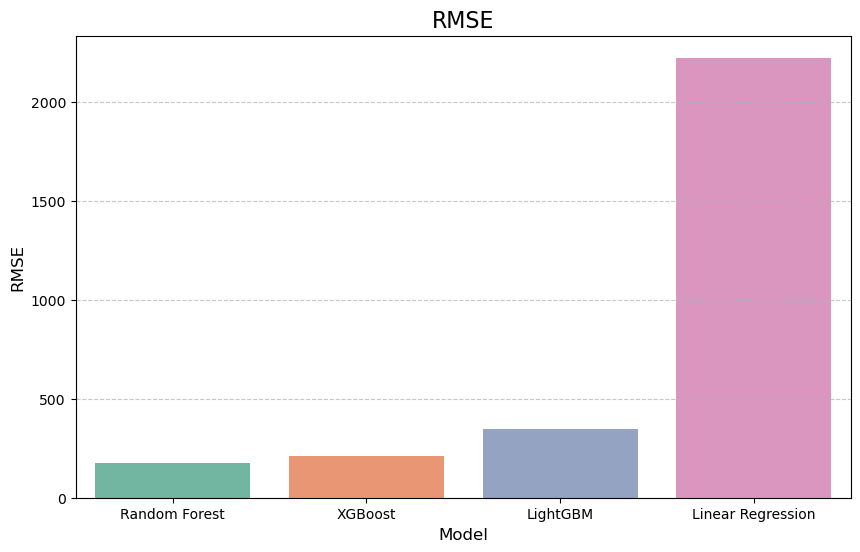

In [12]:
# 2. RMSE 비교 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='RMSE', data=model_performance.sort_values(by='RMSE'), palette='Set2')
plt.title('RMSE', fontsize=16)
plt.ylabel('RMSE', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

C:\Users\user\AppData\Local\Temp\ipykernel_9220\2448327177.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='name', y='R2', data=model_performance.sort_values(by='R2', ascending=False), palette='mako')


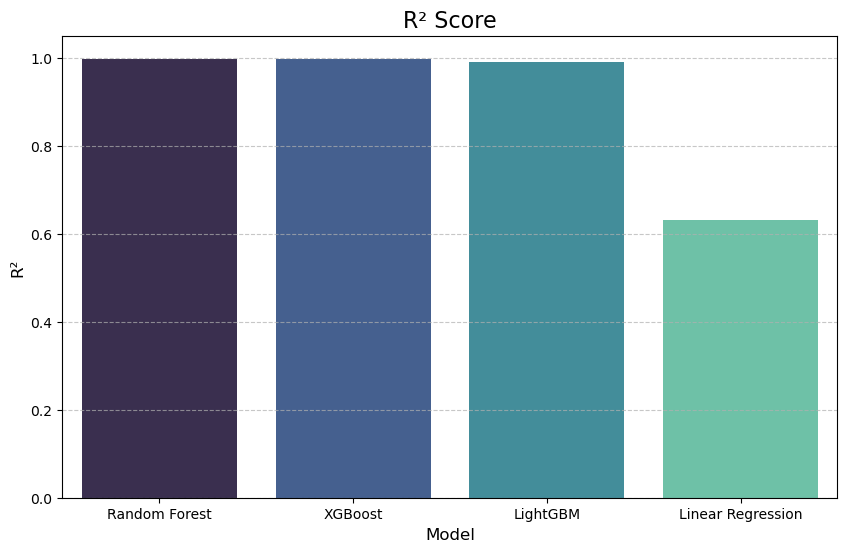

In [13]:
# 3.R2 비교 그래프
plt.figure(figsize=(10, 6))
sns.barplot(x='name', y='R2', data=model_performance.sort_values(by='R2', ascending=False), palette='mako')
plt.title('R² Score', fontsize=16)
plt.ylabel('R²', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 1.05)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()